# DoorDash Challenge Project 

# Part 2: Model

# Applicant: Yu-Ting Shen

## Table of Contents

* [Feature engeering](#Feature-engeering)
* [Model building](#Model-building)

# Import packages

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 100)

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Feature engeering

* From the EDA notebook, I decide the following feature engeering steps:
  * convert data type
  * create new features: `duration`, `month`, `week`, `dayofweek`, `hour`
  * use `created_at` >= 2015-01-01
  * calculate duration mean, std, median, mode for the granularity = [`market_id`, `month`, `week`, `dayofweek`, `hour`]
  * drop rows where `market_id=NaN`, `total_onshift_dashers=NaN`, `total_busy_dashers=NaN`, `total_outstanding_orders=NaN`, `estimated_store_to_consumer_driving_duration=NaN`
  * use absolute value for `total_onshift_dashers`, `total_busy_dashers`, and `total_outstanding_orders`
  * force `total_onshift_dashers` >= `total_busy_dashers`
  
* I can also do the following, but I will do them seperately, not do them in the DataProcessor
  * consider to normalize data using standard scaler or min max scaler
  * consider to use use one-hot encoding for categorical columns

In [3]:
class DataProcessor():
    def __init__(self, path, data_type):
        self.df_input = pd.read_csv(path)
        self.data_type = data_type # save input data is training or testing set
    
    def process_data(self):
        self.convert_data_type()
        self.create_new_features()
        self.data_cleaning()
        
        if self.data_type == "training":
            list_of_dfs = self.calculate_mean_and_std()
            self.add_mean_and_std(list_of_dfs) # This line could produce NaN due to std
        
        # Drop all NaN row if there is any
        self.df_input = self.df_input.dropna(how="any")
        
        self.df_input = self.df_input.sort_values(by="created_at")
    
    def convert_data_type(self):
        for col in self.df_input.columns:
            if col in ["market_id", "store_id"]:
                self.df_input[col] = self.df_input[col].astype("category")
            if col in ["created_at", "actual_delivery_time"]:
                self.df_input[col] = pd.to_datetime(
                    self.df_input[col], 
                    infer_datetime_format=True
                )

    def create_new_features(self):
        # create duration which is the time difference between
        # actual_delivery_time and created_at in seconds
        # only apply to training set
        if self.data_type == "training":
            self.df_input["duration"] = (
                (self.df_input["actual_delivery_time"] - self.df_input["created_at"]) / 
                np.timedelta64(1, 's')
            )

        # extract month, week, dayofweek and hours from created_at
        self.df_input["month"] = self.df_input["created_at"].dt.month
        self.df_input["week"] = self.df_input["created_at"].dt.isocalendar().week
        self.df_input["dayofweek"] = self.df_input["created_at"].dt.dayofweek
        self.df_input["hour"] = self.df_input["created_at"].dt.hour

        # Based on the EDA, I split the dayweek into 2 groups: weekday and weekend
        self.df_input["weekend"] = (
            self.df_input.apply(lambda row:
                1 if row["dayofweek"] >= 5 else 0,
                axis = 1
            )
        )
        
        # Based on the EDA, I split the hour into 3 windows (0, 5),(6, 18),(19-23)
        self.df_input["hour_window"] = (
            self.df_input.apply(lambda row:
                1 if row["hour"] <= 5 else 2 if row["hour"] <= 18 else 3,
                axis = 1
            )
        )

        
    def data_cleaning(self):
        # use created_at > 2015-01-01
        self.df_input = self.df_input.loc[self.df_input["created_at"]>="2015-01-01"]
        
        # Deal with total_onshift_dashers, total_busy_dashers, total_outstanding_orders
        columns = [
            "total_onshift_dashers", 
            "total_busy_dashers", 
            "total_outstanding_orders"
        ]
        # 1. use absolute value for negative value
        for col_name in columns:
            self.df_input[col_name] = abs(self.df_input[col_name])
        
        # 2. # force total_onshift_dashers >= total_busy_dashers
        self.df_input["total_onshift_dashers"] = self.df_input.apply(
            lambda row:
            row["total_onshift_dashers"]
            if row["total_onshift_dashers"] >= row["total_busy_dashers"]
            else row["total_busy_dashers"],
            axis=1
        )
        
        # 3. fill the missing values
        for col_name in columns:
            # groupby same market and same created hour    
            self.df_input[col_name] = (
                self.df_input.groupby(["market_id", "hour"])[col_name]
                .transform(
                    lambda x: x.fillna(x.mean())
                )
            )

            # groupby same store and same created hour 
            self.df_input[col_name] = (
                self.df_input.groupby(["store_id", "hour"])[col_name]
                .transform(
                    lambda x: x.fillna(x.mean())
                )
            )

            # groupby same created hour
            self.df_input[col_name] = (
                self.df_input.groupby(["hour"])[col_name]
                .transform(
                    lambda x: x.fillna(x.mean())
                )
            )
            
        # I create two new features:
        # available_driver: total_onshift_dashers - total_busy_dashers
        self.df_input["available_driver"] = (
            self.df_input["total_onshift_dashers"] - self.df_input["total_busy_dashers"]
        )
        # available_to_deliver: 
        # 0: if total_outstanding_orders >= Available drivers
        # 1: if total_outstanding_orders < Available drivers
        self.df_input["available_to_deliver"] = (
            self.df_input.apply(
                lambda row: 0 if row["total_outstanding_orders"] >= row["available_driver"] else 1,
                axis=1
            )
        )
        # convert available_to_deliver to categorical
        self.df_input["available_to_deliver"] = self.df_input["available_to_deliver"].astype("category")
            
        # Deal with estimated_store_to_consumer_driving_duration
        # 1. fill the missing values using same store and same created hour
        self.df_input["estimated_store_to_consumer_driving_duration"] = (
            self.df_input.groupby(["store_id", "hour"])["estimated_store_to_consumer_driving_duration"]
            .transform(
                lambda x: x.fillna(x.mean())
            )
        )

        # 2. fill the missing values using same store and same created hour
        self.df_input["estimated_store_to_consumer_driving_duration"] = (
            self.df_input.groupby(["hour"])["estimated_store_to_consumer_driving_duration"]
            .transform(
                lambda x: x.fillna(x.mean())
            )
        )
        
        # Drop rows where actual_delivery_time is NaT
        if self.data_type == "training":
            self.df_input = self.df_input.loc[
                self.df_input["actual_delivery_time"].notnull()
            ]
        
    # calculate duration mean for different granularity
    def calculate_duration_mean(self, groupby_col_name, new_col_name):
        df_groupby = (
            self.df_input.groupby(groupby_col_name)[["duration"]]
            .mean().reset_index()
            .rename(columns={"duration": new_col_name})
        )
        return df_groupby

    # calculate std for different granularity
    def calculate_duration_std(self, groupby_col_name, new_col_name):
        df_groupby = (
            self.df_input.groupby(groupby_col_name)[["duration"]]
            .std().reset_index()
            .rename(columns={"duration": new_col_name})
        )
        return df_groupby

    def calculate_mean_and_std(self):
        columns = [
            "market_id",
            "store_id",
            "month",
            "week",
            "dayofweek",
            "hour"
        ]
        
        list_of_dfs = []
        
        for col_name in columns:
            df_duration_mean = self.calculate_duration_mean(col_name, f"dt_{col_name}")
            list_of_dfs.append(df_duration_mean)
            
            df_duration_std = self.calculate_duration_std(col_name, f"sdt_{col_name}")
            list_of_dfs.append(df_duration_std)
            
        return list_of_dfs

    def add_mean_and_std(self, list_of_dfs):
        for df_i in list_of_dfs:
            col_name = df_i.columns[0]
            self.df_input = self.df_input.merge(df_i, on=col_name)


In [4]:
# load historical data and apply data processing
historical_data = DataProcessor("historical_data.csv", "training")

historical_data.process_data()

historical_data.df_input.isnull().sum()

market_id                                       0
created_at                                      0
actual_delivery_time                            0
store_id                                        0
subtotal                                        0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_store_to_consumer_driving_duration    0
duration                                        0
month                                           0
week                                            0
dayofweek                                       0
hour                                            0
weekend                                         0
hour_window                                     0
available_driver                                0
available_to_deliver                            0
dt_market_id                                    0
sdt_market_id                                   0


In [5]:
historical_data.df_input.shape

(195870, 30)

In [6]:
historical_data.df_input.head()

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,duration,month,week,dayofweek,hour,weekend,hour_window,available_driver,available_to_deliver,dt_market_id,sdt_market_id,dt_store_id,sdt_store_id,dt_month,sdt_month,dt_week,sdt_week,dt_dayofweek,sdt_dayofweek,dt_hour,sdt_hour
196374,1.0,2015-01-21 15:22:03,2015-01-21 16:17:43,2966,1058,2.0,1.0,1.0,463.0,3340.0,1,4,2,15,0,2,1.0,0,3088.559233,2159.853855,2582.685185,923.247321,2768.052057,1779.278649,2790.997278,1059.544341,2668.265606,2602.113437,3183.336431,1498.856349
196378,3.0,2015-01-21 15:31:51,2015-01-21 16:16:34,1303,690,2.0,0.0,1.0,458.0,2683.0,1,4,2,15,0,2,2.0,1,2861.711109,1195.939242,2468.666667,576.459938,2768.052057,1779.278649,2790.997278,1059.544341,2668.265606,2602.113437,3183.336431,1498.856349
196376,1.0,2015-01-21 15:39:16,2015-01-21 15:58:11,5551,1867,4.0,1.0,1.0,284.0,1135.0,1,4,2,15,0,2,3.0,1,3088.559233,2159.853855,3204.000000,1352.630893,2768.052057,1779.278649,2790.997278,1059.544341,2668.265606,2602.113437,3183.336431,1498.856349
196372,1.0,2015-01-21 15:40:42,2015-01-21 16:22:37,602,955,3.0,2.0,2.0,377.0,2515.0,1,4,2,15,0,2,1.0,0,3088.559233,2159.853855,2878.357143,1345.937569,2768.052057,1779.278649,2790.997278,1059.544341,2668.265606,2602.113437,3183.336431,1498.856349
196377,1.0,2015-01-21 15:41:33,2015-01-21 16:35:14,5591,825,0.0,0.0,0.0,534.0,3221.0,1,4,2,15,0,2,0.0,0,3088.559233,2159.853855,3043.230769,971.664307,2768.052057,1779.278649,2790.997278,1059.544341,2668.265606,2602.113437,3183.336431,1498.856349


In [7]:
historical_data.df_input.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195870 entries, 196374 to 36259
Data columns (total 30 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     195870 non-null  category      
 1   created_at                                    195870 non-null  datetime64[ns]
 2   actual_delivery_time                          195870 non-null  datetime64[ns]
 3   store_id                                      195870 non-null  category      
 4   subtotal                                      195870 non-null  int64         
 5   total_onshift_dashers                         195870 non-null  float64       
 6   total_busy_dashers                            195870 non-null  float64       
 7   total_outstanding_orders                      195870 non-null  float64       
 8   estimated_store_to_consumer_driving_duration  1958

In [8]:
# load prediction data and apply data processing
predict_data = DataProcessor("predict_data.csv", "testing")

predict_data.process_data()

predict_data.df_input.isnull().sum()

market_id                                       0
created_at                                      0
store_id                                        0
subtotal                                        0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_store_to_consumer_driving_duration    0
delivery_id                                     0
month                                           0
week                                            0
dayofweek                                       0
hour                                            0
weekend                                         0
hour_window                                     0
available_driver                                0
available_to_deliver                            0
dtype: int64

In [9]:
predict_data.df_input.shape

(54528, 17)

In [10]:
predict_data.df_input.head()

,market_id,created_at,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_id,month,week,dayofweek,hour,weekend,hour_window,available_driver,available_to_deliver
27577,1.0,2015-02-18 14:50:28,266,2500,1.0,0.00,0.0,425.0,99834,2,8,2,14,0,2,1.00,1
50927,3.0,2015-02-18 14:59:26,6463,1198,0.5,0.25,1.0,877.0,240577,2,8,2,14,0,2,0.25,0
47372,1.0,2015-02-18 15:04:22,6049,1575,0.0,0.00,0.0,350.0,34717,2,8,2,15,0,2,0.00,0
22766,1.0,2015-02-18 15:13:50,4355,900,1.0,0.00,0.0,299.0,228294,2,8,2,15,0,2,1.00,1
1385,1.0,2015-02-18 15:22:38,2549,1870,3.0,0.00,0.0,1022.0,104625,2,8,2,15,0,2,3.00,1


In [11]:
predict_data.df_input.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54528 entries, 27577 to 34166
Data columns (total 17 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   market_id                                     54528 non-null  category      
 1   created_at                                    54528 non-null  datetime64[ns]
 2   store_id                                      54528 non-null  category      
 3   subtotal                                      54528 non-null  int64         
 4   total_onshift_dashers                         54528 non-null  float64       
 5   total_busy_dashers                            54528 non-null  float64       
 6   total_outstanding_orders                      54528 non-null  float64       
 7   estimated_store_to_consumer_driving_duration  54528 non-null  float64       
 8   delivery_id                                   54528 non-null  

# Train and test split

* The time series data cannot use random shuffle.
* I  use the first 70% as training dataset and the last 30% as testing dataset

In [12]:
def train_and_test_split(df_input, test_size=0.3):
    num_rows = len(df_input)
    num_train = int(np.ceil(num_rows * (1 - test_size)))
    num_test = num_rows - num_train

    print(f"Total rows = {num_rows}")
    print(f"training dataset has {num_train} rows and testing dataset has {num_test} rows.")

    df_train = df_input.iloc[:num_train]
    df_test = df_input.iloc[num_train:]

    return df_train, df_test

In [13]:
df_train, df_test = train_and_test_split(historical_data.df_input)
print(df_train.shape)
print(df_test.shape)

Total rows = 195870
training dataset has 137109 rows and testing dataset has 58761 rows.
(137109, 30)
(58761, 30)


# Baseline Model

* Use the average duration from the historical data as the predict resunts as the baseline model
* But there are several average duration calculated from different granularity
  * dt_market_id
  * dt_store_id
  * dt_week
  * dt_dayofweek
  * dt_hour
* I will use the one with smallest MSE as the baseline model

In [14]:
y_true = df_test["duration"].values

df_metrics = pd.DataFrame(columns=
    ["granularity", "MAE", "MAPE", "MSE", "R2"]
)

for col_name in ["dt_market_id", "dt_store_id", "dt_week", "dt_dayofweek", "dt_hour"]:
    y_pred = df_test[col_name].values
    
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    df_metrics.loc[len(df_metrics.index)] = [col_name, mae, mape, mse, r2]

display(df_metrics)

,granularity,MAE,MAPE,MSE,R2
0,dt_market_id,814.858299,0.312180,3.193728e+06,0.006356
1,dt_store_id,739.199080,0.277593,2.831550e+06,0.119038
2,dt_week,824.311891,0.318113,3.213363e+06,0.000247
3,dt_dayofweek,808.560428,0.308106,3.184746e+06,0.009150
4,dt_hour,782.812524,0.294821,3.125614e+06,0.027548


* Form the above table, using the duration mean calculate by the store_id can get the minimum MAE, MAPE, MSE, and the largest R2. We can use this as the baseline model

# Model building
* We try the following model
  * use linear regression model
  * use kNN model
  * use random forest model
  * use gradient boost model

* In the first trial, I only use the default parameters for the model. Then I will select the best model to to hyperparameter tuning.

In [15]:
class MyModel:
    def __init__(self, df_train, df_test):
        self.df_train = df_train
        self.df_test = df_test
        
        self.model = None

        self.df_metrics = pd.DataFrame(columns=
            ["model", "MAE", "MAPE", "MSE", "R2"]
        )
        
    def calculate_metrics(self, y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        return mae, mape, mse, r2
#         self.df_metrics.loc[len(df_metrics.index)] = [model, mae, mape, mse, r2]
        
        
    def build_linear_regression_model(self):
        columns = self.df_train.columns.difference(["duration"])
        
        X_train = self.df_train[columns].values
        y_train = self.df_train["duration"].values
        
        self.model = LinearRegression()
        self.model.fit(X_train, y_train)
        
        y_pred_train = self.model.predict(X_train)
        train_mae, train_mape, train_mse, train_r2 = self.calculate_metrics(y_train, y_pred_train)
        print("Training metrics:")
        print(f"MAE = {train_mae}, MAPE = {train_mape}, MSE = {train_mse}, R2 = {train_r2}")
        
        # get the importance and make plot
        importance = self.model.coef_
        ticks = range(len(importance))
        
        fig, ax = plt.subplots()
        ax.barh(ticks, importance)
        ax.set_ylabel("features")
        ax.set_yticks(ticks)
        ax.set_yticklabels(columns)
        ax.set_xlabel("importance")
        ax.set_title("Feature importance (i.e. coefficient)")
        plt.show()
        
    def build_knn_model(self, k):
        columns = self.df_train.columns.difference(["duration"])
        
        X_train = self.df_train[columns].values
        y_train = self.df_train["duration"].values
        
        self.model = KNeighborsClassifier(n_neighbors=k)  
        self.model.fit(X_train, y_train)
        
        y_pred_train = self.model.predict(X_train)
        train_mae, train_mape, train_mse, train_r2 = self.calculate_metrics(y_train, y_pred_train)
        print("Training metrics:")
        print(f"MAE = {train_mae}, MAPE = {train_mape}, MSE = {train_mse}, R2 = {train_r2}")
        
    def build_random_forest_model(self, n_estimators, max_depth, min_samples_leaf):
        columns = self.df_train.columns.difference(["duration"])
        
        X_train = self.df_train[columns].values
        y_train = self.df_train["duration"].values
        
        self.model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf
        )
        self.model.fit(X_train, y_train)
        
        y_pred_train = self.model.predict(X_train)
        train_mae, train_mape, train_mse, train_r2 = self.calculate_metrics(y_train, y_pred_train)
        print("Training metrics:")
        print(f"MAE = {train_mae}, MAPE = {train_mape}, MSE = {train_mse}, R2 = {train_r2}")
        
        # get the importance and make plot
        importance = self.model.feature_importances_
        ticks = range(len(importance))
        
        fig, ax = plt.subplots()
        ax.barh(ticks, importance)
        ax.set_xlabel("importance")
        ax.set_ylabel("features")
        ax.set_yticks(ticks)
        ax.set_yticklabels(columns)
        ax.set_title("Feature importance")
        plt.show()
    
    def build_gradient_boost_model(self, max_depth):
        columns = self.df_train.columns.difference(["duration"])
        
        X_train = self.df_train[columns].values
        y_train = self.df_train["duration"].values
        
        self.model = GradientBoostingRegressor(max_depth=max_depth)
        self.model.fit(X_train, y_train)
        
        y_pred_train = self.model.predict(X_train)
        train_mae, train_mape, train_mse, train_r2 = self.calculate_metrics(y_train, y_pred_train)
        print("Training metrics:")
        print(f"MAE = {train_mae}, MAPE = {train_mape}, MSE = {train_mse}, R2 = {train_r2}")
        
        # get the importance and make plot
        importance = self.model.feature_importances_
        ticks = range(len(importance))
        
        fig, ax = plt.subplots()
        ax.barh(ticks, importance)
        ax.set_xlabel("importance")
        ax.set_ylabel("features")
        ax.set_yticks(ticks)
        ax.set_yticklabels(columns)
        ax.set_title("Feature importance")
        plt.show()

    def validate_model(self):
        columns = self.df_train.columns.difference(["duration"])
        
        X_test = self.df_test[columns].values
        y_test = self.df_test["duration"].values
        
        y_pred_test = self.model.predict(X_test)
        test_mae, test_mape, test_mse, test_r2 = self.calculate_metrics(y_test, y_pred_test)
        print("Testing metrics:")
        print(f"MAE = {test_mae}, MAPE = {test_mape}, MSE = {test_mse}, R2 = {test_r2}")
        
        return y_pred_test

In [16]:
columns = [
    "duration",
    "market_id",
    "subtotal",
    "total_onshift_dashers",
    "total_busy_dashers",
    "total_outstanding_orders",
    "estimated_store_to_consumer_driving_duration",
    # "month",
    # "week",
    "dayofweek",
    # "hour",
    "weekend",
    "hour_window",
    "available_driver",
    "available_to_deliver",
]

df_train_sub = df_train[columns].copy()
df_test_sub = df_test[columns].copy()

### Apply one-hot encoding

In [17]:
df_train_sub = pd.get_dummies(
    df_train_sub[columns],
    columns=["market_id", "dayofweek", "weekend", "hour_window", "available_to_deliver"]
)

df_test_sub = pd.get_dummies(
    df_test_sub[columns],
    columns=["market_id", "dayofweek", "weekend", "hour_window", "available_to_deliver"]
)

print(df_train_sub.shape)
print(df_test_sub.shape)

(137109, 27)
(58761, 27)


### Apply normalization

In [18]:
def normalization(data):
    scaler = MinMaxScaler()
    new_data = scaler.fit_transform(data)
    return new_data

columns = [
    "subtotal",
    "total_onshift_dashers",
    "total_busy_dashers",
    "total_outstanding_orders",
    "estimated_store_to_consumer_driving_duration",
    "available_driver"
]

for col_name in columns:
    train_data = df_train_sub[col_name].values.reshape(-1, 1) 
    df_train_sub[col_name] = normalization(train_data)

    test_data = df_test_sub[col_name].values.reshape(-1, 1)
    df_test_sub[col_name] = normalization(test_data)

print(df_train_sub.shape)
print(df_test_sub.shape)

(137109, 27)
(58761, 27)


### Linear regression model

Training metrics:
MAE = 716.2893245519988, MAPE = 0.27144512881670724, MSE = 2075419.4434573953, R2 = 0.1176884329008775


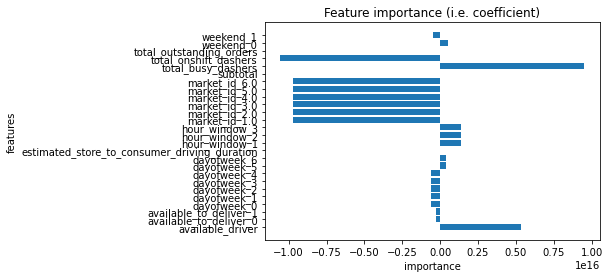

In [19]:
model = MyModel(df_train_sub, df_test_sub)
model.build_linear_regression_model()

* The MAE, MAPE and MSE in the linear regression model are slightly smaller than the baseline model.
* The R2 score in the linear regression model is slightly worse than than the baseline model.

In [20]:
y_pred_test = model.validate_model()

Testing metrics:
MAE = 96186056670065.14, MAPE = 37493743541.47696, MSE = 2.2640042493395083e+28, R2 = -7.043850966899644e+21


### KNN model

In [21]:
for k in [2, 3, 4, 5]:
    print(f"For k = {k}")
    model.build_knn_model(k)

For k = 2
Training metrics:
MAE = 467.6488779000649, MAPE = 0.1263658785640497, MSE = 1952367.4853000168, R2 = 0.17000082998220556
For k = 3
Training metrics:
MAE = 661.7997505634204, MAPE = 0.18616068433491192, MSE = 2324332.2314946502, R2 = 0.011869518668145673
For k = 4
Training metrics:
MAE = 776.8965713410498, MAPE = 0.22338595913652895, MSE = 2560439.3504000464, R2 = -0.08850539240893451
For k = 5
Training metrics:
MAE = 856.1008103042105, MAPE = 0.24972318197956728, MSE = 2728255.934927685, R2 = -0.15984832703671392


The larger k value, the large metrics. Therefore, the k = 2 can give the best metrics results.

In [22]:
model.build_knn_model(2)
y_pred_test = model.validate_model()

Training metrics:
MAE = 467.6488779000649, MAPE = 0.1263658785640497, MSE = 1952367.4853000168, R2 = 0.17000082998220556
Testing metrics:
MAE = 859.6792940896173, MAPE = 0.2857807611052585, MSE = 3418615.1306308606, R2 = -0.06361176222955445


### Random forest model

100
Training metrics:
MAE = 677.2523115061769, MAPE = 0.2573906078923817, MSE = 1860460.2641714374, R2 = 0.2090728375984564


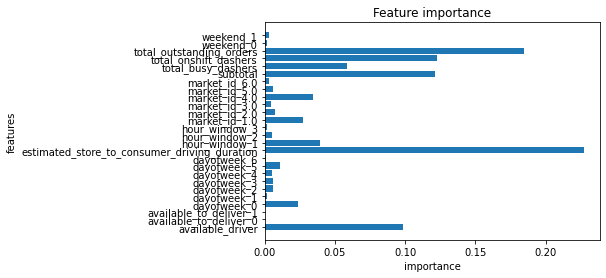

200
Training metrics:
MAE = 677.1643450902633, MAPE = 0.25737389424450835, MSE = 1872424.5610553073, R2 = 0.20398652236414372


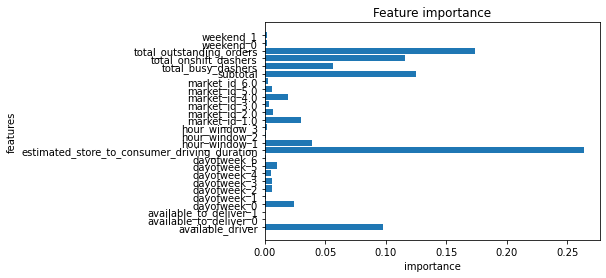

300
Training metrics:
MAE = 677.429951012413, MAPE = 0.25747213043928835, MSE = 1863983.0005073398, R2 = 0.2075752362211516


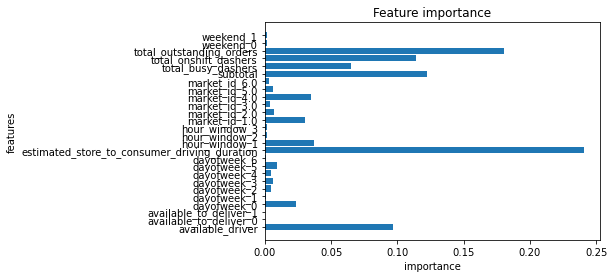

400
Training metrics:
MAE = 677.0211796923656, MAPE = 0.2573676115167448, MSE = 1867541.2400918133, R2 = 0.20606254154452242


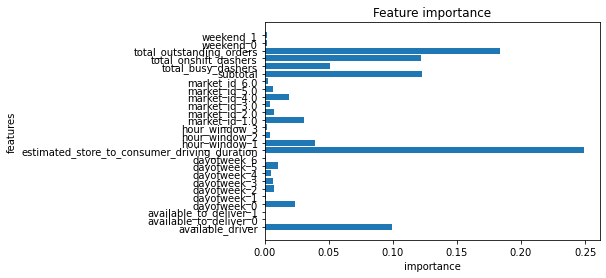

In [23]:
for n in [100, 200, 300, 400]:
    print(n)
    model.build_random_forest_model(n_estimators=n, max_depth=10, min_samples_leaf=10)

n_estimator=300 has the smallest MAE, MAPE, MSE

max_depth=10
Training metrics:
MAE = 677.4376052602851, MAPE = 0.25748759634282214, MSE = 1859677.5406193633, R2 = 0.20940559252470192


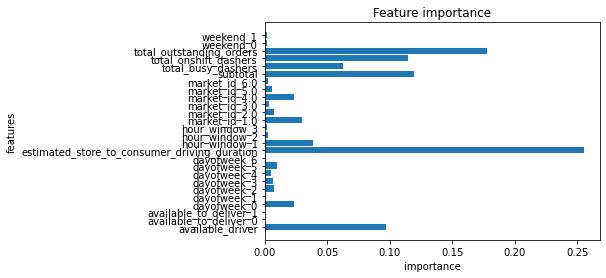

max_depth=20
Training metrics:
MAE = 570.233326430305, MAPE = 0.21401847259491827, MSE = 1629709.760946858, R2 = 0.30717052033473613


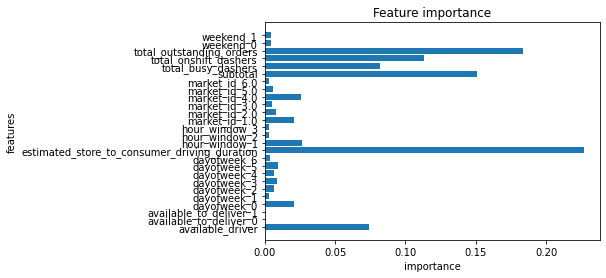

max_depth=30
Training metrics:
MAE = 563.3204755520758, MAPE = 0.2112476110943403, MSE = 1615656.0809034943, R2 = 0.313145083453367


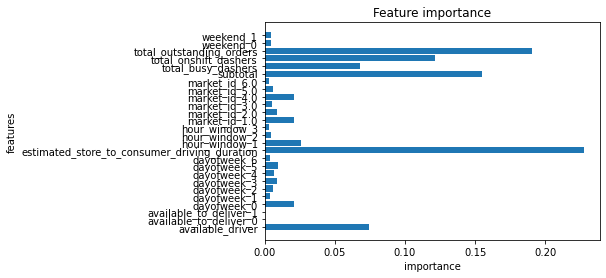

max_depth=40
Training metrics:
MAE = 563.3298894047556, MAPE = 0.21118630493633597, MSE = 1618657.1157826553, R2 = 0.3118692701253678


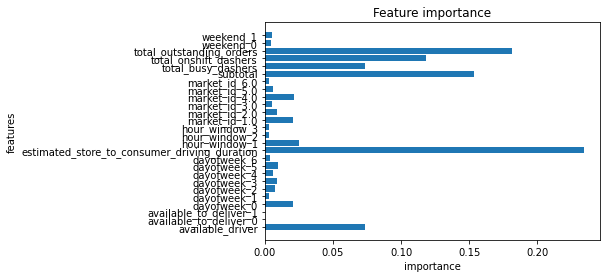

In [24]:
for n in [10, 20, 30, 40]:
    print(f"max_depth={n}")
    model.build_random_forest_model(n_estimators=300, max_depth=n, min_samples_leaf=10)

max_depth=40 has the smallest MAE and MAPE

min_samples_leaf=10
Training metrics:
MAE = 563.7270224257968, MAPE = 0.21135861952760474, MSE = 1613047.1460738883, R2 = 0.31425420546011407


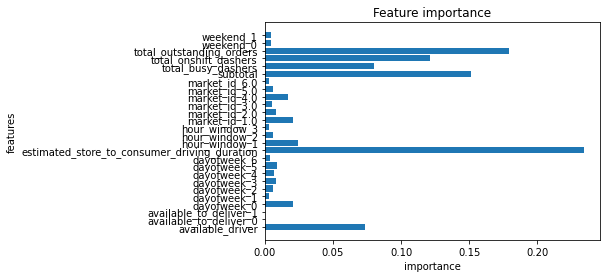

min_samples_leaf=20
Training metrics:
MAE = 616.9290189527144, MAPE = 0.23200253261585566, MSE = 1778963.4302227928, R2 = 0.24371913500186693


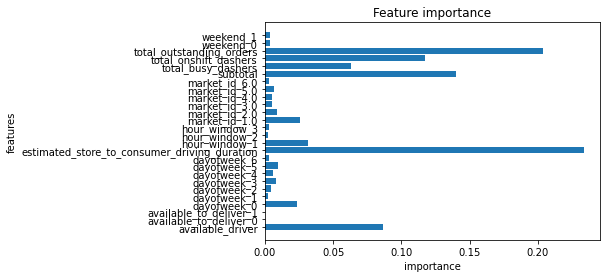

min_samples_leaf=30
Training metrics:
MAE = 637.2128027529595, MAPE = 0.2400139470203291, MSE = 1849540.3634237023, R2 = 0.21371515449091594


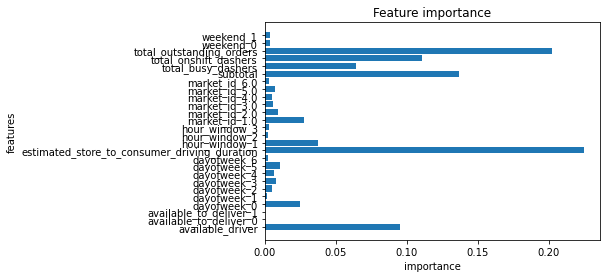

min_samples_leaf=40
Training metrics:
MAE = 649.3613308971741, MAPE = 0.2448537418685215, MSE = 1880019.8273555841, R2 = 0.20075758889093265


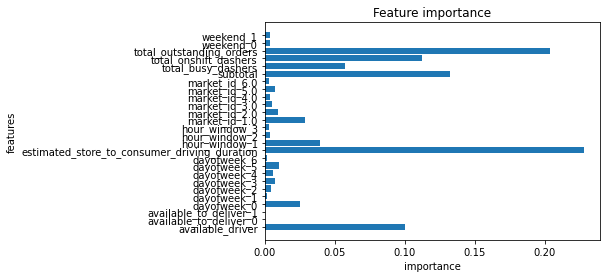

In [25]:
for n in [10, 20, 30, 40]:
    print(f"min_samples_leaf={n}")
    model.build_random_forest_model(n_estimators=300, max_depth=40, min_samples_leaf=n)

min_samples_leaf=10 has the best results

Training metrics:
MAE = 563.6992987794049, MAPE = 0.21132602784802862, MSE = 1616053.2562352614, R2 = 0.3129762345055125


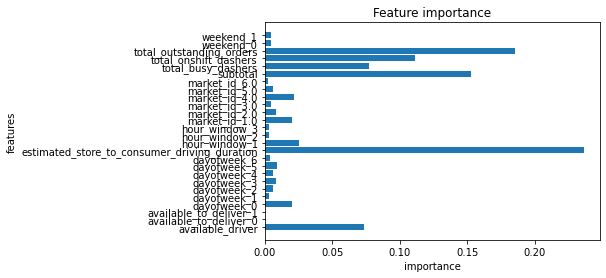

Testing metrics:
MAE = 729.4467676935479, MAPE = 0.27802936921492427, MSE = 2952658.112143285, R2 = 0.08135845132746067


In [26]:
model.build_random_forest_model(n_estimators=300, max_depth=40, min_samples_leaf=10)
y_pred_test = model.validate_model()

### Gradient boost model

max_depth=3
Training metrics:
MAE = 691.6819593476196, MAPE = 0.26230688453381523, MSE = 1897947.7643206443, R2 = 0.19313598439630308


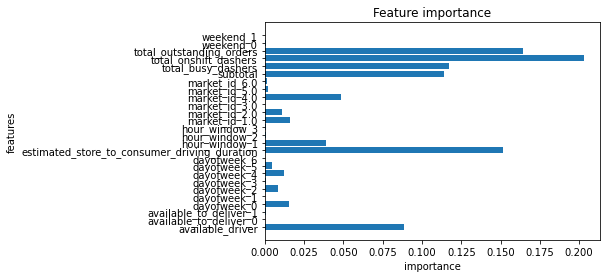

max_depth=4
Training metrics:
MAE = 679.0340456093918, MAPE = 0.2568508980836265, MSE = 1451723.9044705122, R2 = 0.38283666119323967


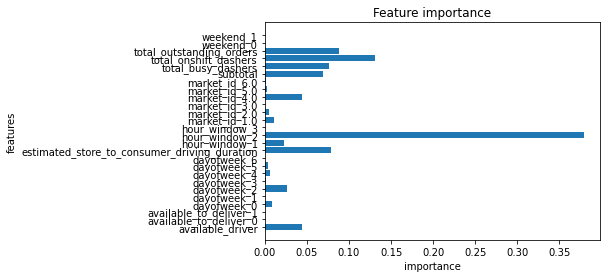

max_depth=5
Training metrics:
MAE = 667.6399081325601, MAPE = 0.2524473442829956, MSE = 1111443.2558763595, R2 = 0.5274982876712397


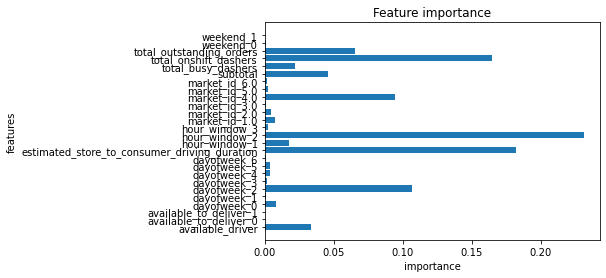

max_depth=6
Training metrics:
MAE = 655.6304795271333, MAPE = 0.24807965066655335, MSE = 932214.1345957067, R2 = 0.6036929708064698


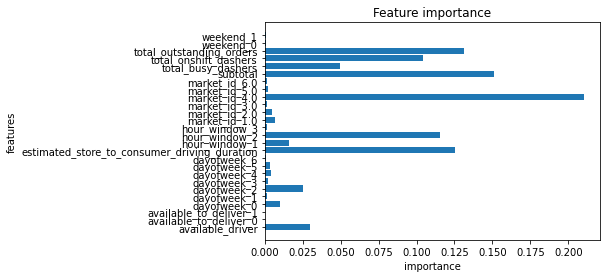

In [27]:
for n in [3, 4, 5, 6]:
    print(f"max_depth={n}")
    model.build_gradient_boost_model(max_depth=n)

max_depth=6 has the best results

Training metrics:
MAE = 667.6399081325603, MAPE = 0.2524473442829956, MSE = 1111443.2558763598, R2 = 0.5274982876712397


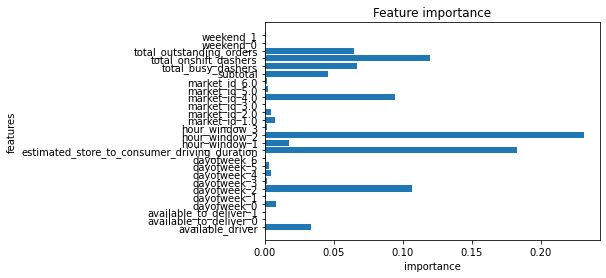

Testing metrics:
MAE = 739.0821133160115, MAPE = 0.28124515647779447, MSE = 2983572.3241208517, R2 = 0.07174031116749191


In [28]:
model.build_gradient_boost_model(max_depth=5)
y_pred_test = model.validate_model()

* Compare with all the models, I decide to use random forest to forecast.

# Forecast

In [39]:
columns = [
    # "duration",
    "market_id",
    "subtotal",
    "total_onshift_dashers",
    "total_busy_dashers",
    "total_outstanding_orders",
    "estimated_store_to_consumer_driving_duration",
    # "month",
    # "week",
    "dayofweek",
    # "hour",
    "weekend",
    "hour_window",
    "available_driver",
    "available_to_deliver",
]

df_sub = pd.get_dummies(
    predict_data.df_input[columns],
    columns=["market_id", "dayofweek", "weekend", "hour_window", "available_to_deliver"]
)

columns = [
    "subtotal",
    "total_onshift_dashers",
    "total_busy_dashers",
    "total_outstanding_orders",
    "estimated_store_to_consumer_driving_duration",
    "available_driver"
]

for col_name in columns:
    data = df_sub[col_name].values.reshape(-1, 1) 
    df_sub[col_name] = normalization(data)

In [40]:
df_sub.head()

,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,available_driver,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,weekend_0,weekend_1,hour_window_1,hour_window_2,hour_window_3,available_to_deliver_0,available_to_deliver_1
27577,0.083542,0.005714,0.000000,0.000000,0.274194,0.015873,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1
50927,0.040033,0.002857,0.001479,0.003425,0.565806,0.003968,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0
47372,0.052632,0.000000,0.000000,0.000000,0.225806,0.000000,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0
22766,0.030075,0.005714,0.000000,0.000000,0.192903,0.015873,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1
1385,0.062490,0.017143,0.000000,0.000000,0.659355,0.047619,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1


In [41]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54528 entries, 27577 to 34166
Data columns (total 26 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   subtotal                                      54528 non-null  float64
 1   total_onshift_dashers                         54528 non-null  float64
 2   total_busy_dashers                            54528 non-null  float64
 3   total_outstanding_orders                      54528 non-null  float64
 4   estimated_store_to_consumer_driving_duration  54528 non-null  float64
 5   available_driver                              54528 non-null  float64
 6   market_id_1.0                                 54528 non-null  uint8  
 7   market_id_2.0                                 54528 non-null  uint8  
 8   market_id_3.0                                 54528 non-null  uint8  
 9   market_id_4.0                                 54528 non-n

Training metrics:
MAE = 563.7863771970593, MAPE = 0.21138811453876594, MSE = 1609948.3497781935, R2 = 0.31557157955738113


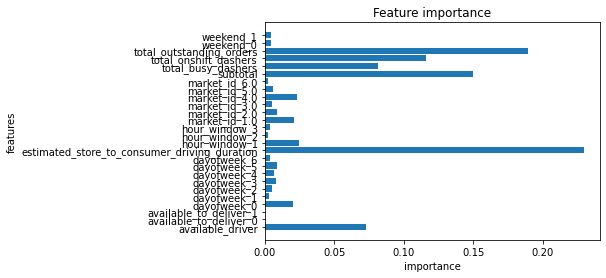

In [42]:
# Get the random forest model
model.build_random_forest_model(n_estimators=300, max_depth=40, min_samples_leaf=10)
rf_model = model.model

In [85]:
# Forecast results
X_test = df_sub.values
y_pred = rf_model.predict(X_test)

# Arrange the forecasted results
df_pred = pd.DataFrame(y_pred, columns=["predicted_duration"])
df_pred["delivery_id"] = predict_data.df_input["delivery_id"].values
df_pred = df_pred.loc[:, ["delivery_id", "predicted_duration"]]
df_pred.to_csv("data_to_predict.csv", index=False)

In [86]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54528 entries, 0 to 54527
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   delivery_id         54528 non-null  int64  
 1   predicted_duration  54528 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 852.1 KB


In [87]:
df_pred.head()

,delivery_id,predicted_duration
0,99834,1970.124465
1,240577,2100.550719
2,34717,2080.985401
3,228294,2193.874483
4,104625,2051.360627
